<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Catchup_Assignment_for_Midterm_Exam/a)_yoga_pose_detection_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Step 1: Unzip the Uploaded Dataset

In [2]:
import zipfile
import os

# Set zip and extract path
zip_path = "/content/archive (14).zip"
extract_dir = "/content/yoga_dataset"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset extracted to:", extract_dir)


Dataset extracted to: /content/yoga_dataset


## Step 2: Set Paths for Train and Test

In [4]:
# Define the TRAIN and TEST directories
train_dir = "/content/yoga_dataset/DATASET/TRAIN"
test_dir = "/content/yoga_dataset/DATASET/TEST"

## Step 3: Get Class Folders from TRAIN

In [5]:
# Only include actual pose class folders (e.g., downdog, goddess, etc.)
class_folders = sorted([
    d for d in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, d))
])

print(f"✅ Found {len(class_folders)} pose classes:")
print("📂 Sample classes:", class_folders[:5])

✅ Found 5 pose classes:
📂 Sample classes: ['downdog', 'goddess', 'plank', 'tree', 'warrior2']


## Step 4: Install & Import MoveNet Dependencies

In [6]:
!pip install -q tensorflow tensorflow-hub opencv-python

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

## Step 4: Load MoveNet Lightning Model

In [7]:
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
input_size = 192

##  Step 5: Define Helper Functions

In [8]:
def detect_pose(image):
    image_resized = tf.image.resize_with_pad(tf.expand_dims(image, axis=0), input_size, input_size)
    input_image = tf.cast(image_resized, dtype=tf.int32)
    outputs = movenet.signatures['serving_default'](input_image)
    keypoints = outputs['output_0'].numpy()[0, 0, :, :]
    return keypoints

def extract_keypoint_vector(image):
    keypoints = detect_pose(image)
    return keypoints.flatten()

## Step 6: Extract Features from TRAIN Images

In [9]:
X = []
y = []
class_names = class_folders

for idx, class_name in enumerate(class_folders):
    folder_path = os.path.join(train_dir, class_name)
    image_files = os.listdir(folder_path)[:50]  # limit for faster training

    for img_name in image_files:
        try:
            img_path = os.path.join(folder_path, img_name)
            img = tf.io.read_file(img_path)
            img = tf.image.decode_jpeg(img, channels=3)
            vec = extract_keypoint_vector(img)
            X.append(vec)
            y.append(idx)
        except Exception as e:
            print(f"⚠️ Skipped {img_name} — {e}")


## Step 7: Prepare Data for Model

In [10]:
from tensorflow.keras.utils import to_categorical

X = np.array(X)
y = to_categorical(np.array(y), num_classes=len(class_names))

print("Training data:", X.shape, y.shape)

Training data: (250, 51) (250, 5)


## Step 8: Build the Neural Network Classifier

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(51,)),  # 17 keypoints × 3 (x, y, confidence)
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')  # Output layer for N pose classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,237 (59.52 KB)

 Trainable params: 15,237 (59.52 KB)

 Non-trainable params: 0 (0.00 B)

## Step 9: Train the Model

In [12]:
history = model.fit(X, y, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.1526 - loss: 1.6346 - val_accuracy: 0.0000e+00 - val_loss: 2.5360
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3989 - loss: 1.4032 - val_accuracy: 0.0000e+00 - val_loss: 3.1606
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3362 - loss: 1.3878 - val_accuracy: 0.0000e+00 - val_loss: 3.4845
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4171 - loss: 1.3177 - val_accuracy: 0.0000e+00 - val_loss: 3.6560
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4254 - loss: 1.2438 - val_accuracy: 0.0000e+00 - val_loss: 3.8153
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4603 - loss: 1.2612 - val_accuracy: 0.0000e+00 - val_loss: 4.0622
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6269 - loss: 1.0412 - val_accuracy: 0.0000e+00 - val_loss: 4.2912
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5463 - loss: 1.04

##  Step 10: Plot Training Accuracy and Loss

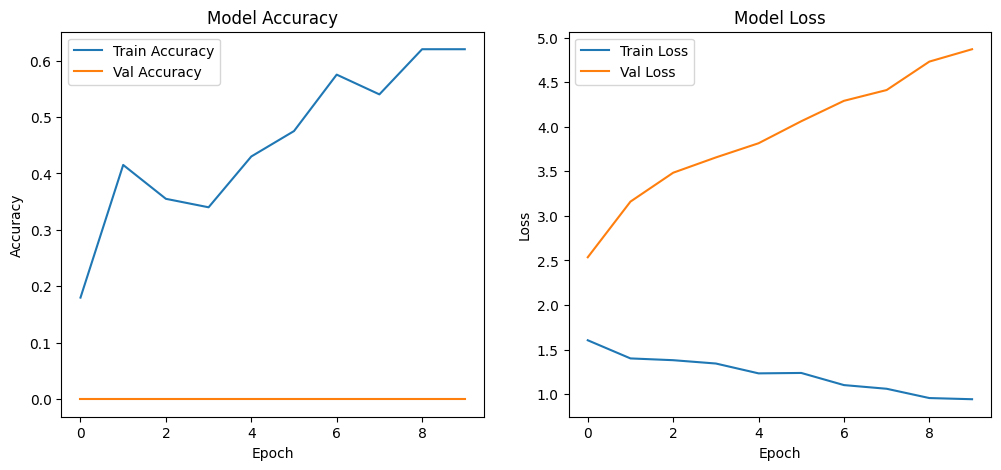

In [13]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

##  Step 11: Extract TEST Features with MoveNet

In [14]:
X_test = []
y_test = []

for idx, class_name in enumerate(class_names):
    folder_path = os.path.join(test_dir, class_name)
    image_files = os.listdir(folder_path)[:20]  # optional limit for speed

    for img_name in image_files:
        try:
            img_path = os.path.join(folder_path, img_name)
            img = tf.io.read_file(img_path)
            img = tf.image.decode_jpeg(img, channels=3)
            vec = extract_keypoint_vector(img)
            X_test.append(vec)
            y_test.append(idx)
        except Exception as e:
            print(f"⚠️ Skipped {img_name} — {e}")

## Step 12: Prepare TEST Data for Evaluation

In [15]:
X_test = np.array(X_test)
y_test = to_categorical(np.array(y_test), num_classes=len(class_names))

print("Test data shape:", X_test.shape, y_test.shape)

Test data shape: (100, 51) (100, 5)


In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7543 - loss: 1.2269
Test Accuracy: 68.00%


## Step 14: Predict and Visualize a Test Sample

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


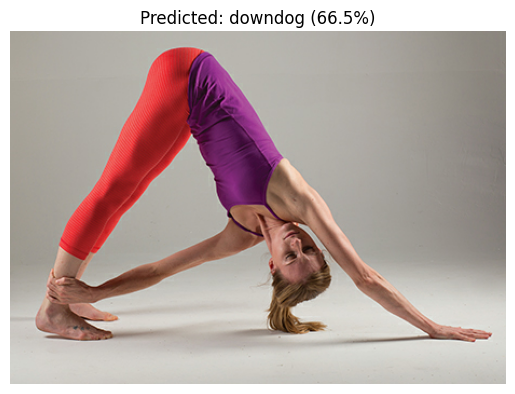

In [17]:
# Pick a test image
sample_class = class_names[0]
sample_img_path = os.path.join(test_dir, sample_class, os.listdir(os.path.join(test_dir, sample_class))[0])

sample_img = tf.io.read_file(sample_img_path)
sample_img = tf.image.decode_jpeg(sample_img, channels=3)
vec = extract_keypoint_vector(sample_img)

# Predict
pred = model.predict(np.expand_dims(vec, axis=0))[0]
predicted_class = np.argmax(pred)

# Show image with prediction
plt.imshow(sample_img.numpy())
plt.title(f"Predicted: {class_names[predicted_class]} ({pred[predicted_class]*100:.1f}%)")
plt.axis('off')
plt.show()